# **LOAD DATASET & LIBRARY**

In [ ]:
pip install nltk


In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import spacy
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


from spacy import displacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()
nlp=spacy.load("en_core_web_lg")

In [ ]:
dataset = pd.read_excel('/content/dataset.xls')
dataset.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Mon Dec 04 12:01:29 +0000 2023,1731640000000000000,"Menurut laporan BPS, Sumatra Utara menjadi pro...",0,0,0,0,in,1316330000000000000,1731640000000000000,databoksid,https://twitter.com/databoksid/status/17316448...
1,Fri Dec 01 08:00:00 +0000 2023,1730500000000000000,"Diguyur hujan deras, jalan di Lebak, Banten, l...",0,0,0,0,in,61377303,1730500000000000000,Lintas_MNCTV,https://twitter.com/Lintas_MNCTV/status/173049...
2,Fri Dec 01 06:14:11 +0000 2023,1730470000000000000,"Bapak/ibu, terdpt jalan yang rusak di daerah G...",0,1,1,0,in,1574830000000000000,1730470000000000000,Eddy30749724,https://twitter.com/Eddy30749724/status/173047...
3,Fri Dec 01 05:42:40 +0000 2023,1730460000000000000,"Catatan infrastruktur jalan di Indonesia, berd...",0,1,30,30,in,53878998,1730460000000000000,datanesia_id,https://twitter.com/datanesia_id/status/173046...
4,Tue Nov 28 03:50:18 +0000 2023,1729350000000000000,Jenazah pria bernama Arju (45) di Polewali Man...,0,0,0,1,in,375995332,1729350000000000000,SeputariNews,https://twitter.com/SeputariNews/status/172934...


In [ ]:
dataset.isnull().sum()

created_at             0
id_str                 0
full_text              5
quote_count            0
reply_count            0
retweet_count          0
favorite_count         0
lang                   0
user_id_str            0
conversation_id_str    0
username               0
tweet_url              0
dtype: int64

In [ ]:
dataset_cleaned_rows = dataset.dropna()
dataset_cleaned_columns = dataset.dropna(axis=1)

# **PRE PROCESSING** #

In [ ]:
def Most_Words_used(full_text , num_of_words) :
    all_text = ''.join(dataset[full_text].values)

    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)


    words = all_text.split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

In [ ]:
def DataPrep(full_text) :
    full_text = re.sub('<.*?>', '', full_text)
    full_text = re.sub(r'http\S+', '', full_text)
    full_text = re.sub(r'@\S+', '', full_text)
    full_text = re.sub(r'#\S+', '', full_text)
    full_text = re.sub(r'\d+', '', full_text)
    full_text = re.sub(r'[^\w\s]', '', full_text)
    full_text = re.sub(r'@(\w+)', '', full_text)

    tokens = nltk.word_tokenize(full_text)

    #remove puncs
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]

    #remove stop words
    stop_words = set(stopwords.words('english'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # lemmatization
    words = [lemma.lemmatize(w) for w in words]

    text = ' '.join(words)

    return text

In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
dataset['full_text'] = dataset['full_text'].astype(str).apply(DataPrep)


In [ ]:
print(dataset['full_text'])

0       menurut laporan bps sumatra utara menjadi prov...
1       diguyur hujan deras jalan di lebak banten long...
2       bapakibu terdpt jalan yang rusak di daerah gra...
3       catatan infrastruktur jalan di indonesia berda...
4       jenazah pria bernama arju di polewali mandar t...
                              ...                        
6054    orang jawa solo ewuh pekewuh dan tidak mau the...
6055    kak maaf oot mau nanya apakah memang di pedala...
6056    ï sedangkan pada rambut dan kuku tidak ada lag...
6057    berangkat dari meeting informal tersebut bayer...
6058    testimoni hari ini yang punya masalah sinyal j...
Name: full_text, Length: 6059, dtype: object


In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 540 duplicated tweets, we will remove them.


In [ ]:
dataset.drop_duplicates("full_text", inplace=True)

In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 0 duplicated tweets, we will remove them.


# **VADER LABELLING** #

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [ ]:
# Inisialisasi VADER
sia = SentimentIntensityAnalyzer()

# Fungsi untuk menentukan kategori urgent atau tidak urgent berdasarkan sentimen
def categorize_sentiment(row):
    sentiment_scores = sia.polarity_scores(row['full_text'])

    # Misalnya, jika nilai sentimen negatif lebih tinggi, kategorikan sebagai 'urgent'
    if any(word in row['full_text'].lower() for word in ['tanya','mari','nanya', 'bertanya']):
        return 'tidak urgent'
    elif any(word in row['full_text'].lower() for word in ['berkali-kali', 'meresahkan', 'sudah lama','terus','banyak','berhari-hari','berbulan-bulan','berminggu-minggu','mati','bahaya','berbahaya','sekali','kehilangan nyawa']):
        return 'urgent'
    else:
        return 'tidak urgent'

# Terapkan fungsi pada setiap baris data untuk menentukan kategori
dataset['label'] = dataset.apply(categorize_sentiment, axis=1)

# Tampilkan data yang telah ditambahkan kategori urgent atau tidak urgent
print(dataset[['full_text', 'label']])

                                              full_text         label
0     menurut laporan bps sumatra utara menjadi prov...  tidak urgent
1     diguyur hujan deras jalan di lebak banten long...  tidak urgent
2     bapakibu terdpt jalan yang rusak di daerah gra...  tidak urgent
3     catatan infrastruktur jalan di indonesia berda...  tidak urgent
4     jenazah pria bernama arju di polewali mandar t...  tidak urgent
...                                                 ...           ...
6054  orang jawa solo ewuh pekewuh dan tidak mau the...  tidak urgent
6055  kak maaf oot mau nanya apakah memang di pedala...  tidak urgent
6056  ï sedangkan pada rambut dan kuku tidak ada lag...  tidak urgent
6057  berangkat dari meeting informal tersebut bayer...  tidak urgent
6058  testimoni hari ini yang punya masalah sinyal j...  tidak urgent

[5519 rows x 2 columns]


In [ ]:
dataset['label'].value_counts()

tidak urgent    3908
urgent          1611
Name: label, dtype: int64

In [ ]:
!pip install xlwt

# Simpan dataframe yang sudah dilabeli ke file Excel
labeled_file_path = 'data_twitter_labeled.xls'  # Ubah ekstensi file sesuai kebutuhan, misalnya .xls atau .xlsx
dataset.to_excel(labeled_file_path, index=False)

# Berikan tautan untuk mengunduh file labeled Excel
download_link = f'<a href="{labeled_file_path}" download>Klik di sini</a> untuk mengunduh file labeled Excel.'

In [ ]:
from google.colab import files

files.download('data_twitter_labeled.xls')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **LOAD DATASET LABELED**

In [ ]:
pip install rank_bm25

In [ ]:
import pandas as pd
#preprocesing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
#split data
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
# mb25
from rank_bm25 import BM25Okapi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [ ]:
dataset_label = pd.read_excel('/content/data_twitter_labeled.xls')
dataset_label.head()

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,label
0,Mon Dec 04 12:01:29 +0000 2023,1731640000000000000,menurut laporan bps sumatra utara menjadi prov...,0,0,0,0,in,1316330000000000000,1731640000000000000,databoksid,https://twitter.com/databoksid/status/17316448...,tidak urgent
1,Fri Dec 01 08:00:00 +0000 2023,1730500000000000000,diguyur hujan deras jalan di lebak banten long...,0,0,0,0,in,61377303,1730500000000000000,Lintas_MNCTV,https://twitter.com/Lintas_MNCTV/status/173049...,tidak urgent
2,Fri Dec 01 06:14:11 +0000 2023,1730470000000000000,bapakibu terdpt jalan yang rusak di daerah gra...,0,1,1,0,in,1574830000000000000,1730470000000000000,Eddy30749724,https://twitter.com/Eddy30749724/status/173047...,tidak urgent
3,Fri Dec 01 05:42:40 +0000 2023,1730460000000000000,catatan infrastruktur jalan di indonesia berda...,0,1,30,30,in,53878998,1730460000000000000,datanesia_id,https://twitter.com/datanesia_id/status/173046...,tidak urgent
4,Tue Nov 28 03:50:18 +0000 2023,1729350000000000000,jenazah pria bernama arju di polewali mandar t...,0,0,0,1,in,375995332,1729350000000000000,SeputariNews,https://twitter.com/SeputariNews/status/172934...,tidak urgent


In [ ]:
# Menggunakan LabelEncoder untuk mengonversi label-string menjadi nilai numerik
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])

# Menampilkan dataset setelah transformasi
print(dataset.head())

                                           full_text  label  \
0  menurut laporan bps sumatra utara menjadi prov...      0   
1  diguyur hujan deras jalan di lebak banten long...      0   
2  bapakibu terdpt jalan yang rusak di daerah gra...      0   
3  catatan infrastruktur jalan di indonesia berda...      0   
4  jenazah pria bernama arju di polewali mandar t...      0   

                                      processed_text  
0  menurut laporan bps sumatra utara menjadi prov...  
1  diguyur hujan deras jalan di lebak banten long...  
2  bapakibu terdpt jalan yang rusak di daerah gra...  
3  catatan infrastruktur jalan di indonesia berda...  
4  jenazah pria bernama arju di polewali mandar t...  


In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['full_text','label']]

# Replacing the values.
dataset['label'] = dataset['label'].replace(4,1)

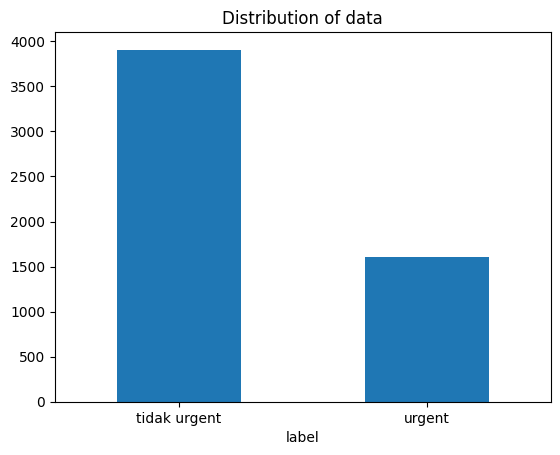

In [ ]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['tidak urgent','urgent'], rotation=0)

In [ ]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
dataset['processed_text'] = dataset.full_text.apply(preprocess_apply)

CPU times: user 167 ms, sys: 1.58 ms, total: 168 ms
Wall time: 169 ms


# **SPLIT DATASET (80:20)**

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = np.array(dataset['full_text']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.2, random_state = 0)

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 2000
CPU times: user 870 ms, sys: 12.1 ms, total: 882 ms
Wall time: 540 ms


In [ ]:
# Defining the model input length.
input_length = 100

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_length = 3000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 3000


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (4414, 100)
X_test.shape : (1104, 100)


In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (3000, 100)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          300000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 100, 200)          240800    
 onal)                                                           
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 100)           100100    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 100)               0         
 obalMaxPooling1D)                                               
                                                   

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
4/4 [==============================] - 52s 10s/step - loss: 0.6235 - accuracy: 0.6040 - val_loss: 0.5696 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 39s 9s/step - loss: 0.5302 - accuracy: 0.7369 - val_loss: 0.5383 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 36s 9s/step - loss: 0.4899 - accuracy: 0.7747 - val_loss: 0.5040 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 39s 10s/step - loss: 0.4493 - accuracy: 0.8285 - val_loss: 0.4471 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 36s 9s/step - loss: 0.4102 - accuracy: 0.8515 - val_loss: 0.4110 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 37s 9s/step - loss: 0.3834 - accuracy: 0.8593 - val_loss: 0.4031 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 36s 9s/step - loss: 0.3629 - accura

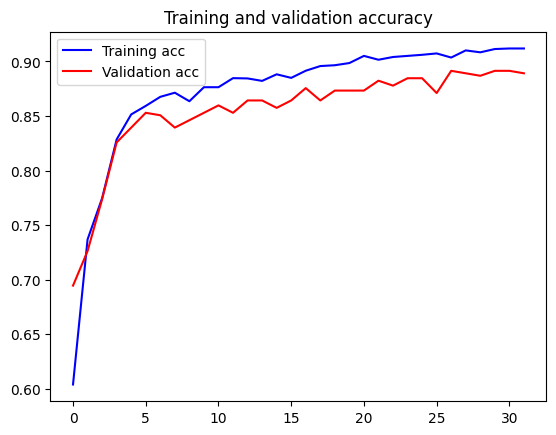

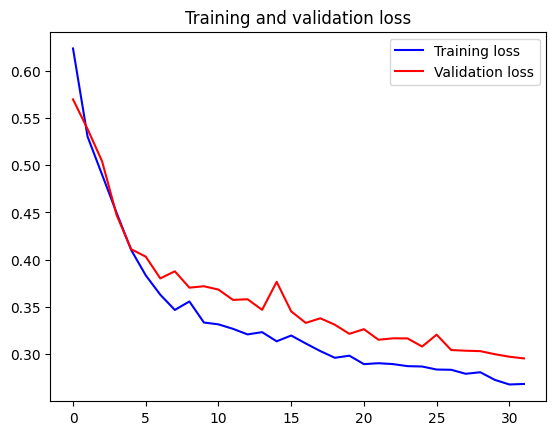

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def ConfusionMatrix(y_pred, y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Tidak urgent', 'Urgent']
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='', xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size':14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':18}, pad=20)

35/35 [==============================] - 6s 158ms/step


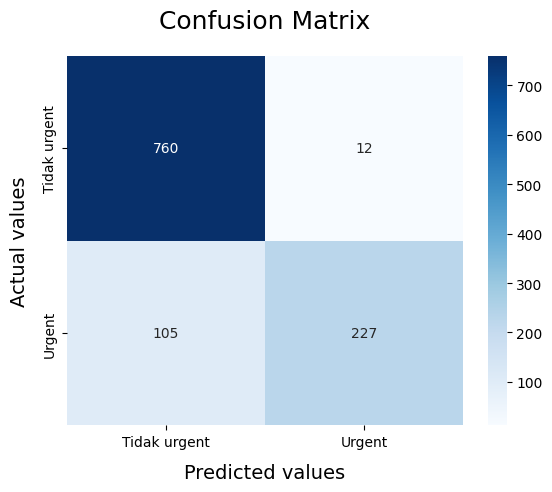

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       772
           1       0.95      0.68      0.80       332

    accuracy                           0.89      1104
   macro avg       0.91      0.83      0.86      1104
weighted avg       0.90      0.89      0.89      1104

